# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.parameter import Parameter
from tqdm.notebook import trange, tqdm

from line_regression import get_line_data, plot_regression, DynamicRegressionPlot
from torch_utils import seed_everything

# fix random seeds for reproducibility
seed_everything(42)

In [2]:
torch.__version__

'1.9.0+cu111'

## Dataset
Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

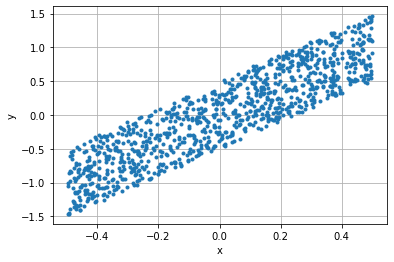

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Input pipeline

In [4]:
# CPU/GPU Tensors
device = 'cpu' #'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

In [5]:
# Initialize with random normal distribution
slope = Parameter(torch.randn([1], device=device))
offset = Parameter(torch.randn([1], device=device))
parameters = [slope, offset]

parameters

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [6]:
y_hat = slope*x + offset
error = (y_hat - y)**2
mse = error.mean()

print(mse)

tensor(0.3456, grad_fn=<MeanBackward0>)


In [7]:
mse.backward()

print([p.grad.item() for p in parameters])

[-0.2869439125061035, 0.25376182794570923]


  0%|          | 0/100 [00:00<?, ?it/s]

[1.95463228225708, -0.030287936329841614]


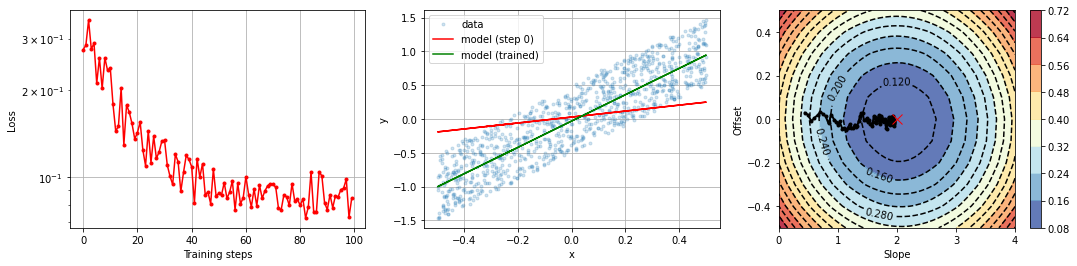

In [8]:
iters = 100
history = []
batch_size = 100
lr = 0.02 * batch_size**0.5
plot = DynamicRegressionPlot(ground_truth, display_every=10)

for i in trange(iters):
    # Sample batch
    batch = torch.randint(len(y), [batch_size])
    
    # Calculate loss
    y_hat = slope*x[batch] + offset
    error = (y_hat - y[batch])**2
    mse = error.mean()
    
    # Calculate gradients
    mse.backward()

    # Training step
    with torch.no_grad():
        for p in parameters:
            # SGD step
            p -= lr*p.grad
            # Clear gradients
            p.grad = None
        history.append([slope.item(), offset.item(), mse.item()])
#         plot.update_graph(history, x_train, y_train)
        
plot_regression(history, x_train, y_train, ground_truth)
print([p.item() for p in parameters])

<br><br><br><br><br><br><br><br><br><br>

<mark>Exercise 1</mark>: Try different batch sizes:
 * `batch_size = 1000` (The whole dataset)
 * `batch_size = 100` (Something between 1 and the size of whole dataset.)
 * `batch_size = 1`

1. Check the SGD trajectories. Why are they different?
2. The case `batch_size = 1` is quite slow compared to `batch_size = 100` and `batch_size = 1000`. Why?

<br><br>

# Distributed Example

In [9]:
import ipcmagic
%ipcluster start -n 2 --mpi

  0%|          | 0/2 [00:00<?, ?engine/s]

In [10]:
%%px
import os
import socket
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.parameter import Parameter
from tqdm import trange, tqdm

from line_regression import get_line_data, plot_regression, DynamicRegressionPlot
from torch_utils import seed_everything

# fix random seeds for reproducibility
seed_everything(42)

# Setup environment for torch.distributed.init_process_group
os.environ['MASTER_PORT'] = '29500'
os.environ['WORLD_SIZE'] = os.environ['SLURM_NNODES']
os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = os.environ['SLURM_NODEID']

world_size = int(os.environ['SLURM_NNODES'])
rank = int(os.environ['SLURM_NODEID'])

print(socket.gethostname(), rank, world_size)

[stdout:0] nid02130 0 2
[stdout:1] nid02131 1 2


In [11]:
master_address = f"'{socket.gethostbyname(socket.gethostname())}'"
%px os.environ['MASTER_ADDR'] = $master_address
%px print(os.environ['MASTER_ADDR'])

[stdout:1] 148.187.40.99
[stdout:0] 148.187.40.99


In [12]:
%%px
import torch.distributed as dist

if not dist.is_initialized():
    # Environment variable initialization
    dist.init_process_group(backend="nccl")

nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

# GPU Tensors
device = 'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

slope = Parameter(torch.randn([1], device=device))
offset = Parameter(torch.randn([1], device=device))
parameters = [slope, offset]

### Task 1: Broadcast parameters from rank=0 to all others
with torch.no_grad():
    ### make sure all ranks have the same parameters
    for p in parameters:
        dist.broadcast(p, src=0)
    print(dist.get_rank(), [p.item() for p in parameters])

history = []

[stdout:0] 0 [0.19401879608631134, 0.13913755118846893]
[stdout:1] 1 [0.19401879608631134, 0.13913755118846893]


[stderr:0] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.
[stderr:1] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


In [13]:
%%px

iters = 100
batch_size = 100
lr = 0.02 * batch_size**0.5

for i in trange(iters):
    # Sample batch
    batch = torch.randint(len(y), [batch_size])
    
    # Calculate loss
    y_hat = slope*x[batch] + offset
    error = (y_hat - y[batch])**2
    mse = error.mean()
    
    # Calculate gradients
    mse.backward()

    # Training step
    with torch.no_grad():
        for p in parameters:
            ### Task 2: Average gradients with all_reduce
            ### make sure all ranks have the same gradients
            dist.all_reduce(p.grad, op=dist.ReduceOp.SUM)
            p.grad /= world_size
            # SGD step
            p -= lr*p.grad
            # Clear gradients
            p.grad = None
        history.append([slope.item(), offset.item(), mse.item()])

print(dist.get_rank(), [p.item() for p in parameters])

 35%|███▌      | 35/100 [00:00<00:00, 294.60it/s]


[stdout:1] 1 [1.9488325119018555, -0.027497246861457825]
[stdout:0] 0 [1.9488325119018555, -0.027497246861457825]


100%|██████████| 100/100 [00:00<00:00, 292.74it/s]
[stderr:1] 
[stderr:0] 


[stdout:0] 0 [1.9488325119018555, -0.027497246861457825]


[output:0]

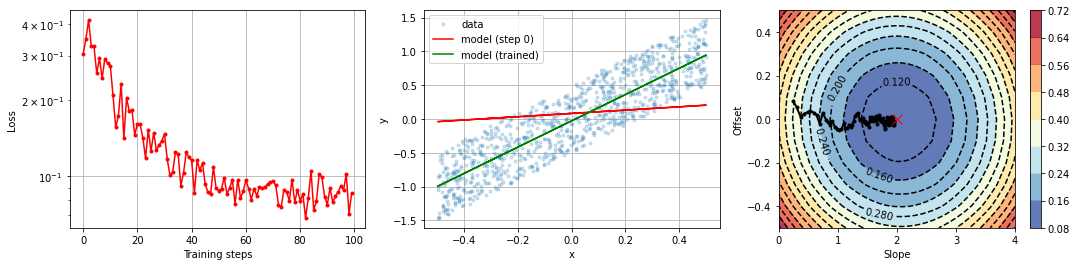

In [14]:
%%px --targets 0

plot_regression(history, x_train, y_train, ground_truth)
print(dist.get_rank(), [p.item() for p in parameters])

In [15]:
%ipcluster stop